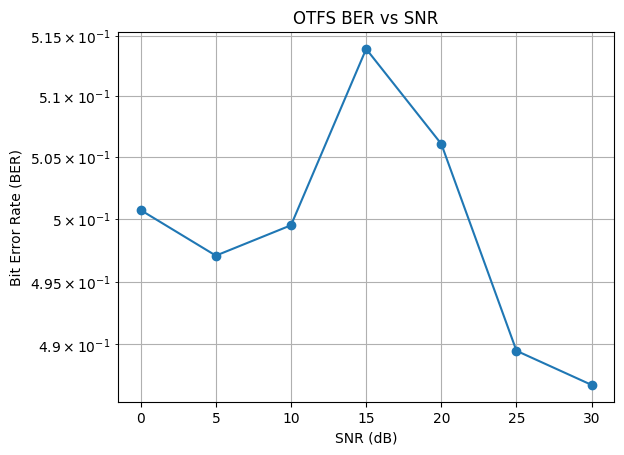

In [2]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
import matplotlib.pyplot as plt

# Function to add white Gaussian noise to a signal
def awgn(signal, snr):
    snr_linear = 10**(snr/10)
    power_signal = np.mean(np.abs(signal)**2)
    power_noise = power_signal / snr_linear
    noise = np.sqrt(power_noise) * np.random.normal(size=signal.shape)
    return signal + noise

# Given parameters
T = 50e-6
Delf = 20e3

# User inputs for M, N, and P
M = int(input("Enter the value of M: "))
N = int(input("Enter the value of N: "))
P = int(input("Enter the value of P: "))

# Creating arrays for delay and Doppler axes
delay_axis = np.linspace(0, T, N, endpoint=False)
doppler_axis = np.linspace(-Delf/2, Delf/2, N, endpoint=False)
dd_xmit = np.zeros((N, M))

# Transmit symbol coordinates
tx_symbol_n = [0]
tx_symbol_m = [1]

# Generating the transmitted signal in the delay-Doppler domain
for i in range(len(tx_symbol_n)):
    n = N//2 - tx_symbol_n[i]
    m = M//2 - tx_symbol_m[i]
    M_ax, N_ax = np.meshgrid(np.arange(-M//2+m, M//2+m), np.arange(-N//2+n, N//2+n))
    dd_xmit += np.sinc(M_ax/(0.5*np.pi)) * np.sinc(N_ax/(0.5*np.pi))

# Performing FFT and IFFT operations to convert to time-frequency domain
X = fftshift(fft(fftshift(ifft(dd_xmit, axis=0), axes=0), axis=1), axes=1)
s_mat = ifft(X, M, axis=0) * np.sqrt(M)
s = s_mat.flatten()  # Flattening the matrix to get the transmitted signal

# Initializing received signal
BER = []
SNR_range = np.arange(0, 35, 5)  # SNR values
total_bits = len(s)

for snr in SNR_range:
    r = np.zeros_like(s)
    
    # Generating random channel coefficients, delays, and Doppler shifts
    channel_coefficients = np.random.rand(P)
    channel_delay = np.random.randint(1, M, P)
    channel_doppler = np.random.randint(1, N, P)
    
    # Generating the received signal considering channel effects
    for i in range(len(channel_delay)):
        r += np.roll(s * np.exp(-1j*2*np.pi*channel_doppler[i]/(M*N) * np.arange(1, M*N+1)), -channel_delay[i])
    
    # Adding white Gaussian noise
    r = awgn(r, snr)
    
    # Convert received signal back to time-frequency domain
    r_mat = np.reshape(r, (N, M))
    Y = fft(r_mat, M, axis=0) / np.sqrt(M)
    dd_rx = fftshift(ifft(fftshift(fft(Y, axis=1), axes=1), axis=0), axes=0)
    
    # Compute Bit Error Rate (BER)
    received_bits = (np.real(dd_rx) > 0).astype(int).flatten()
    transmitted_bits = (np.real(dd_xmit) > 0).astype(int).flatten()
    bit_errors = np.sum(received_bits != transmitted_bits)
    BER.append(bit_errors / total_bits)

# Plot BER vs SNR
plt.figure()
plt.semilogy(SNR_range, BER, 'o-')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('OTFS BER vs SNR')
plt.grid(True, which='both')
plt.show()